# Tracking Particle Events from the CERN Large Hadron Collider
Based on the TrackML Kaggle competition (2018).

<div align="center">
    <img src="https://www.popsci.com/uploads/2022/07/06/Depositphotos_287972174_L.jpg?auto=webp&width=1440&height=960 48" width="500"/>
    <p><b>Figure 1.</b> The Large Hadron Collider at CERN in Geneva</p>
</div>

The subject of this data is the large hadron collider (LHC), a particle accelerator located in Geneva at one of the most notorious physics institutions in the world, CERN. A particle accelerator simulates an environment that allows scientists to force particles—in this case photons—to collide. This allows us to observe the interactions that take place between collisions [(Doe Explains...Particle Accelerators)](www.energy.gov/science/doe-explainsparticle-accelerators). One specific thing we can observe from these interactions is the production of smaller base particles that make up the atoms we know. For example, scientists were able to observe the Higgs Boson, a fundamental particle that gives mass to electrons and quarks. Today, scientists run experiments with the LHC in hopes of finding new fundamental particles, such as the particle that may make up dark matter [(Atlas Collaboration, 2023)](atlas.cern/Updates/Briefing/Anomaly-Detection). The ability to observe these collisions and their products is essential in ground breaking research on fundamental particles in physics.

Research at CERN relies heavily on data science and analysis. With multiple pedabytes (that's millions of gigabytes) of data now available, it is crucial to create machine learning models and algorithms that can automate analyses and processes. About 5 years ago, CERN released a [Kaggle competition](https://kaggle.com/competitions/trackml-particle-identification) with a large dataset of 8,850 simulated particle events. The competition presented competitors with simulated data of an event in which many particles are released into the LHC. The goal of the competition is to be able to track each particle's path using collections of 'hits' on different sensors within the LHC.

This competition presents 6 datasets: one test dataset and five training datasets. Each file of data includes four CSV files for an independent simulated event. These CSV files are cells, hits, particles, and truth. We want to group hit measurements—which are x, y, and z coordinates of a particle interaction with a detector—into tracks—a set of hits associated with a single particle. Thankfully, the competition provides a python package called the [TrackML Library](https://github.com/LAL/trackml-library) that aids users in working with the data and grouping the four CSV files by event number, amongst other things. In this project, it is used to load in datasets for each event.

With predictions of particle movement within the LHC during an event, we can get two main important observations. First, we can predict which particles may collide and try to focus on that collision event. Second, predictions make it easier to 'spot' any outliers, or particles that do not follow a predicted track. These outliers may be other particles produced by collisions that we have yet to discover.

In this analysis, I will explore some of the data given to us so I and you, the reader, can understand this complex dataset a bit more. Then, I will produce a deep learning model to predict particle tracks using the hit data and analyze its prediction and loss scores.

## 🔷 Importing Tools & Data

A python package was built specifically to aid in working with this data. It is installed from a GitHub repository, which can be accessed [here](https://github.com/LAL/trackml-library.git).

In [1]:
# Installing special TrackML data library
%%capture
%pip install -e git+https://github.com/LAL/trackml-library.git#egg=trackml

UsageError: Line magic function `%%capture` not found.


We will also import our basic data tools and machine learning algorithms.

In [237]:
# Basic tools
import os

# Numerical tools
import numpy as np
import pandas as pd

# TrackML dataset tools
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning Tools, Utilities, and Scoring Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score

# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.semi_supervised import LabelPropagation, SelfTrainingClassifier
from sklearn.cluster import KMeans, DBSCAN

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

## 🔷 Exploring the Datasets

As we touched on in the introduction, the data is presented in six chunks. We are given a test data folder, which has the hit and cell CSV files for each event. Our other five train datasets include hit, cell, particle, and truth CSV files for each event. Let's explore what is in each CSV file. We will use event 000001000 for this example.

In [3]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('input/train_100_events', event_prefix))

### 📊 The Cells CSV File

The cell data represents the detector cells (also called modules) that were activated by each hit. It can be thought of as a pixel or small area on a detector.

 - **hit_id**: numerical identifier of the hit as defined in the hits file.
 - **ch0, ch1**: channel identifier/coordinates unique within one module.
 - **value**: signal value information, e.g. how much charge a particle has
deposited.

In [4]:
print(f'There are a total of {cells.shape[0]} instances in cells')

There are a total of 664996 instances in cells


In [5]:
cells.describe()

hit_id            ch0            ch1         value
count  664996.000000  664996.000000  664996.000000  6.649960e+05
mean    49603.957174     211.529248     444.395715  3.560307e-01
std     32415.296519     156.399517     411.081790  4.324583e-01
min         1.000000       0.000000       0.000000  1.461840e-07
25%     25174.000000      97.000000      55.000000  5.364857e-02
50%     36148.000000     191.000000     340.000000  6.512935e-02
75%     78196.000000     287.000000     802.000000  1.000000e+00
max    120939.000000    1195.000000    1279.000000  1.000000e+00

In [6]:
cells.nunique()

hit_id    120939
ch0         1194
ch1         1280
value     333091
dtype: int64

The hit_id just represents the hit from the hits CSV file. It seems that there are multiple instances for the same hit ID, as there are about 665,000 instances in the files but only 120,000 unique instances of hit_id. The channels both have minimum values of 0. This aligns with the Kaggle page which states, "Depending on the detector type only one of the channel identifiers is valid," which means that for some detectors, it will only have a value for either ch0 or ch1, but not both. The channels also do not have a large number of unique values, which means the same channels (or parts of a module) are being hit multiple times. Value can range from a very small number to 1. It does not exceed 1. Let's look at the distributions of these columns.

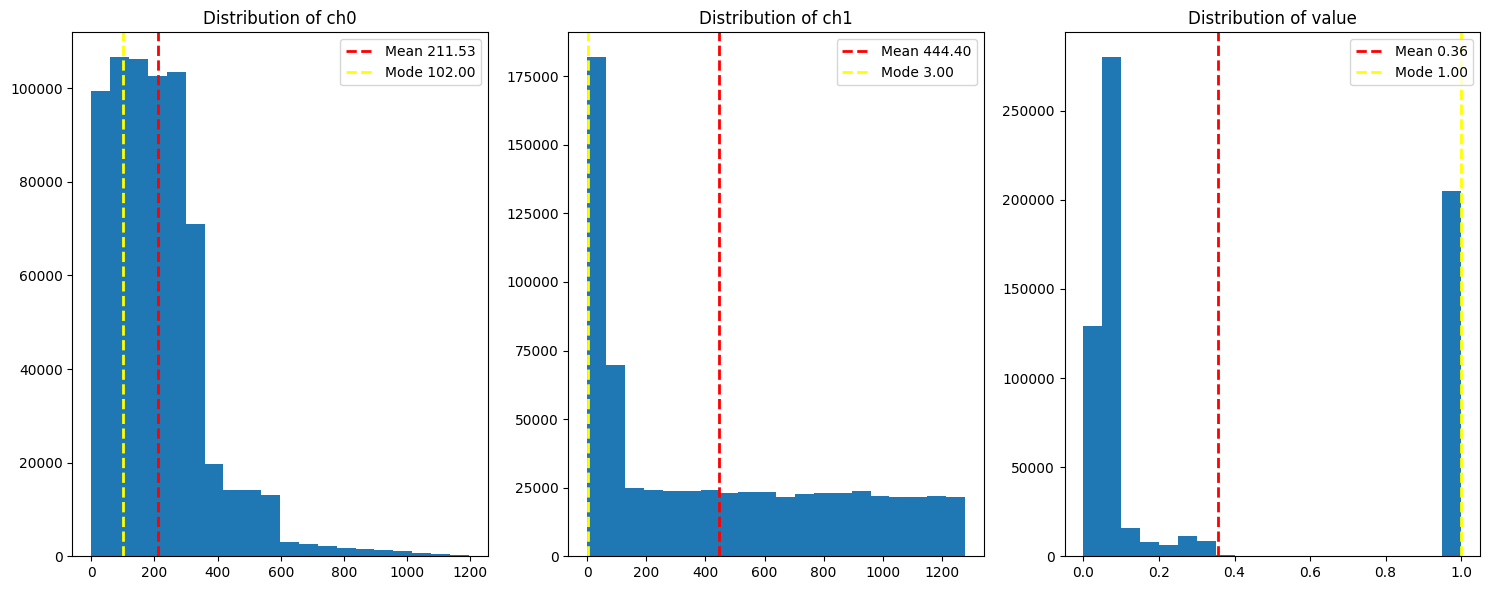

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
ax1.hist(cells['ch0'], bins=20)
ax1.axvline(cells['ch0'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean {cells["ch0"].mean():.2f}')
ax1.axvline(cells['ch0'].mode()[0], color='yellow', linestyle='dashed', linewidth=2, label=f'Mode {cells["ch0"].mode()[0]:.2f}')
ax1.set_title('Distribution of ch0')
ax1.legend()
ax2.hist(cells['ch1'], bins=20)
ax2.axvline(cells['ch1'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean {cells["ch1"].mean():.2f}')
ax2.axvline(cells['ch1'].mode()[0], color='yellow', linestyle='dashed', linewidth=2, label=f'Mode {cells["ch1"].mode()[0]:.2f}')
ax2.set_title('Distribution of ch1')
ax2.legend()
ax3.hist(cells['value'], bins=20)
ax3.axvline(cells['value'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean {cells["value"].mean():.2f}')
ax3.axvline(cells['value'].mode()[0], color='yellow', linestyle='dashed', linewidth=2, label=f'Mode {cells["value"].mode()[0]:.2f}')
ax3.set_title('Distribution of value')
ax3.legend()
plt.tight_layout()
plt.show()

From these distributions, we can see that majority of ch0 values are less than 300, with a peak around 100. Most of ch1 values are less than 100, with the mode occuring at a value of 3. And most of the value values are less than 0.3 or equal to 1.

### 📊 **The Particles CSV File** 
The particle data represents the value for each particle associated with the event.

 - **particle_id**: numerical identifier of the particle inside the event.
 - **vx, vy, vz**: initial position or vertex (in millimeters) in global
coordinates.
 - **px, py, pz**: initial momentum (in GeV/c) along each global axis.
 - **q**: particle charge (as multiple of the absolute electron charge).
 - **nhits**: number of hits generated by this particle.

Each instance in this file is a particle. The v coordinates are the initial position of each particle, and the p coordinates are the initial momenta of each particle. We also have the particle charge and the number of hits each particle generates in the event.

In [8]:
particles.describe()

particle_id            vx            vy            vz            px  \
count  1.226300e+04  12263.000000  12263.000000  12263.000000  12263.000000   
mean   4.803273e+17      1.107652      0.767732      7.498849     -0.003691   
std    2.983347e+17    124.103058    124.627594    537.856995      0.930213   
min    4.503668e+15   -955.513977   -901.664978  -2955.500000    -45.300701   
25%    2.161771e+17     -0.017552     -0.013040     -5.444660     -0.215898   
50%    4.548682e+17      0.000457      0.002574     -0.438758     -0.005679   
75%    7.431018e+17      0.014919      0.013532      6.016730      0.203908   
max    9.683079e+17    968.200012    980.807007   2950.000000     53.201599   

                 py            pz             q         nhits  
count  12263.000000  12263.000000  12263.000000  12263.000000  
mean       0.000103      0.100067      0.107233      8.424121  
std        0.640033      7.765764      0.994274      5.033464  
min      -16.516300    -95.573402     -1.000000      0.000000  
25%       -0.208301     -0.815998     -1.000000      4.000000  
50%        0.006612      0.001188      1.000000     10.000000  
75%        0.215444      0.848551      1.000000     12.000000  
max       11.169400    459.528015      1.000000     19.000000

In [9]:
particles.nunique()

particle_id    12263
vx              2317
vy              2318
vz              1891
px             12221
py             12216
pz             12237
q                  2
nhits             20
dtype: int64

It seems that charge (q) can either be -1 or 1, so a particle will either be positively or negatively charged. A particle can have 0 to 19 hits per event. It seems the initial x and y coordinates can be between ±1000 and the initial z coordinates can be between ±3000. Momentum can be either positive or negative.

Let's look at how many positively and negatively charged particles we have here.

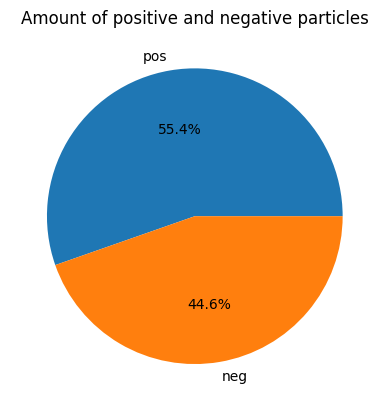

In [10]:
labels = ['pos', 'neg']
sizes = particles['q'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Amount of positive and negative particles")
plt.show()

I would assume that if a particle starts with more momentum, then it will move around faster and longer, so it will generate more hits. The opposite will happen if the particle starts with less momentum. Therefore, I would assume that momentum and nhits are correlated. Let's check this and other correlations with a heatmap.

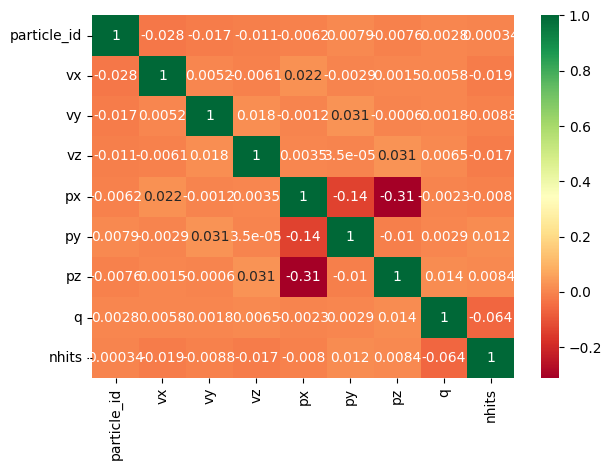

In [11]:
sns.heatmap(particles.corr(), annot=True, cmap="RdYlGn")
plt.tight_layout()
plt.show()

Nothing seems very correlated, which disproves my previous assumption. The only things with a very slight correlation are the momentum coordinates. This makes sense that they are correlated as the starting momentum is an overall vectorized value inherent of the particle, which is represented by 3 dimensions (x, y, z) in this dataset. 

Let's look at the initial position of the particles to see if we can spot any trends.

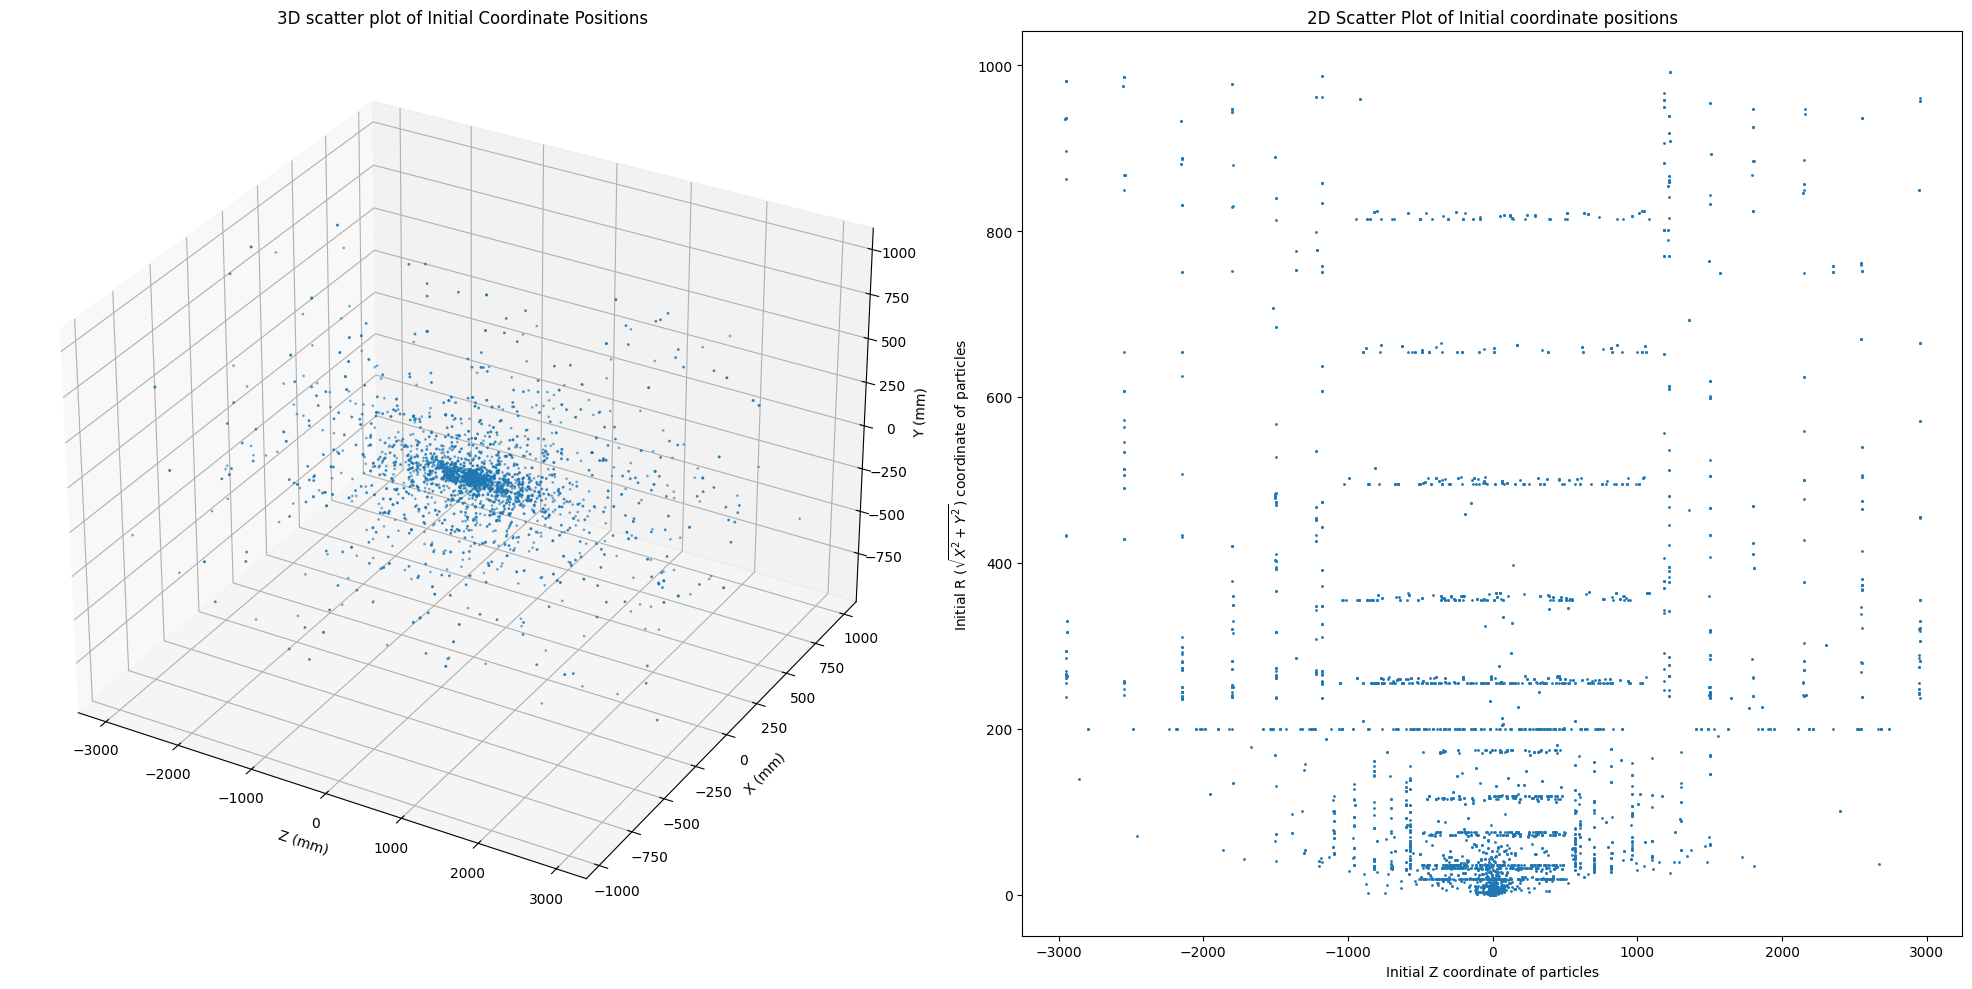

In [157]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(particles['vz'], particles['vx'], particles['vy'], s=1, alpha=0.5)
ax1.set_xlabel('Z (mm)')
ax1.set_ylabel('X (mm)')
ax1.set_zlabel('Y (mm)')
ax1.set_title('3D scatter plot of Initial Coordinate Positions')

# ax2 = fig.add_subplot(132)
# ax2.scatter(x=particles['vx'], y=particles['vy'], s=1)
# ax2.set_xlabel('Initial X coordinate of particles')
# ax2.set_ylabel('Initial Y coordinate of particles')
# ax2.set_title('2D Scatter Plot of Initial coordinate positions')

ax3 = fig.add_subplot(122)
r = (particles['vx']**2 + particles['vy']**2)**0.5
ax3.scatter(x=particles['vz'], y=r, s=1)
ax3.set_ylabel('Initial R ($\sqrt{X^2 + Y^2}$) coordinate of particles')
ax3.set_xlabel('Initial Z coordinate of particles')
ax3.set_title('2D Scatter Plot of Initial coordinate positions')
plt.tight_layout()
plt.show()

We can see that many of the particles originate from the center at 0, 0 in the 2D plane and 0, 0, 0 in the 3D plane.

### 📊 **The Truth CSV File**
This file maps hits to particles and includes the particles' position and momentum when it hit.

 - **hit_id**: numerical identifier of the hit as defined in the hits file.
 - **particle_id**: numerical identifier of the generating particle as defined
in the particles file. A value of 0 means that the hit did not originate
from a reconstructible particle, but e.g. from detector noise.
 - **tx, ty, tz**: true intersection point in global coordinates (in
millimeters) between the particle trajectory and the sensitive surface.
 - **tpx, tpy, tpz**: true particle momentum (in GeV/c) in the global
coordinate system at the intersection point. The corresponding vector
is tangent to the particle trajectory at the intersection point.
 - **weight**: per-hit weight used for the scoring metric; total sum of weights
within one event equals to one.


In [13]:
truth.describe()

hit_id   particle_id             tx             ty  \
count  120939.00000  1.209390e+05  120939.000000  120939.000000   
mean    60470.00000  4.103431e+17      -1.767838       4.754221   
std     34912.22644  3.231682e+17     305.710358     305.167908   
min         1.00000  0.000000e+00   -1024.839966   -1025.099976   
25%     30235.50000  1.035873e+17    -100.141998     -95.873302   
50%     60470.00000  3.648081e+17      -1.651420       1.012140   
75%     90704.50000  7.115699e+17      97.251553     103.222000   
max    120939.00000  9.683079e+17    1025.349976    1024.849976   

                  tz            tpx            tpy             tpz  \
count  120939.000000  120939.000000  120939.000000   120939.000000   
mean       -2.310570    -528.416260     437.340668      -17.349043   
std      1061.912964  188079.859375  189808.328125   272779.312500   
min     -2955.500000 -999841.000000 -999861.000000 -1000000.000000   
25%      -654.862000      -0.329628      -0.309520       -2.038540   
50%        -1.759190      -0.006623       0.006257       -0.007396   
75%       655.110504       0.308269       0.329654        2.038135   
max      2955.500000  999910.000000  999798.000000  1000000.000000   

              weight  
count  120939.000000  
mean        0.000008  
std         0.000008  
min         0.000000  
25%         0.000004  
50%         0.000007  
75%         0.000011  
max         0.000165

In [14]:
truth.nunique()

hit_id         120939
particle_id     10566
tx             117887
ty             117878
tz              64560
tpx            117931
tpy            117925
tpz            116993
weight          32307
dtype: int64

The weights are a specially applied set of data used for the final scoring metrics. The description of weight from the competition description is as follows: 
 - the few first (starting from the center of the detector) and last hits have a larger weight
 - hits from the more straight tracks (more rare, but more interesting) have a larger weight
 - random hits or hits from very short tracks have weight zero
 - the sum of the weights of all the hits of one event is 1 by construction
 - the hit weights are available in the truth file. They are not revealed for the test dataset

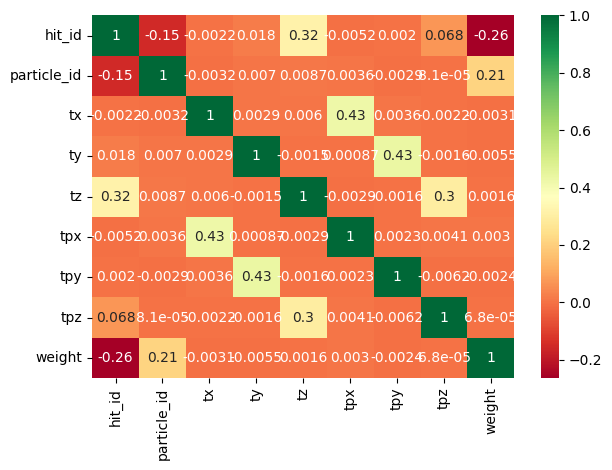

In [15]:
sns.heatmap(truth.corr(), annot=True, cmap="RdYlGn")
plt.tight_layout()
plt.show()

There seems to be some correlation between the position and momentum data. It would be interesting to see if the relationship is linear.

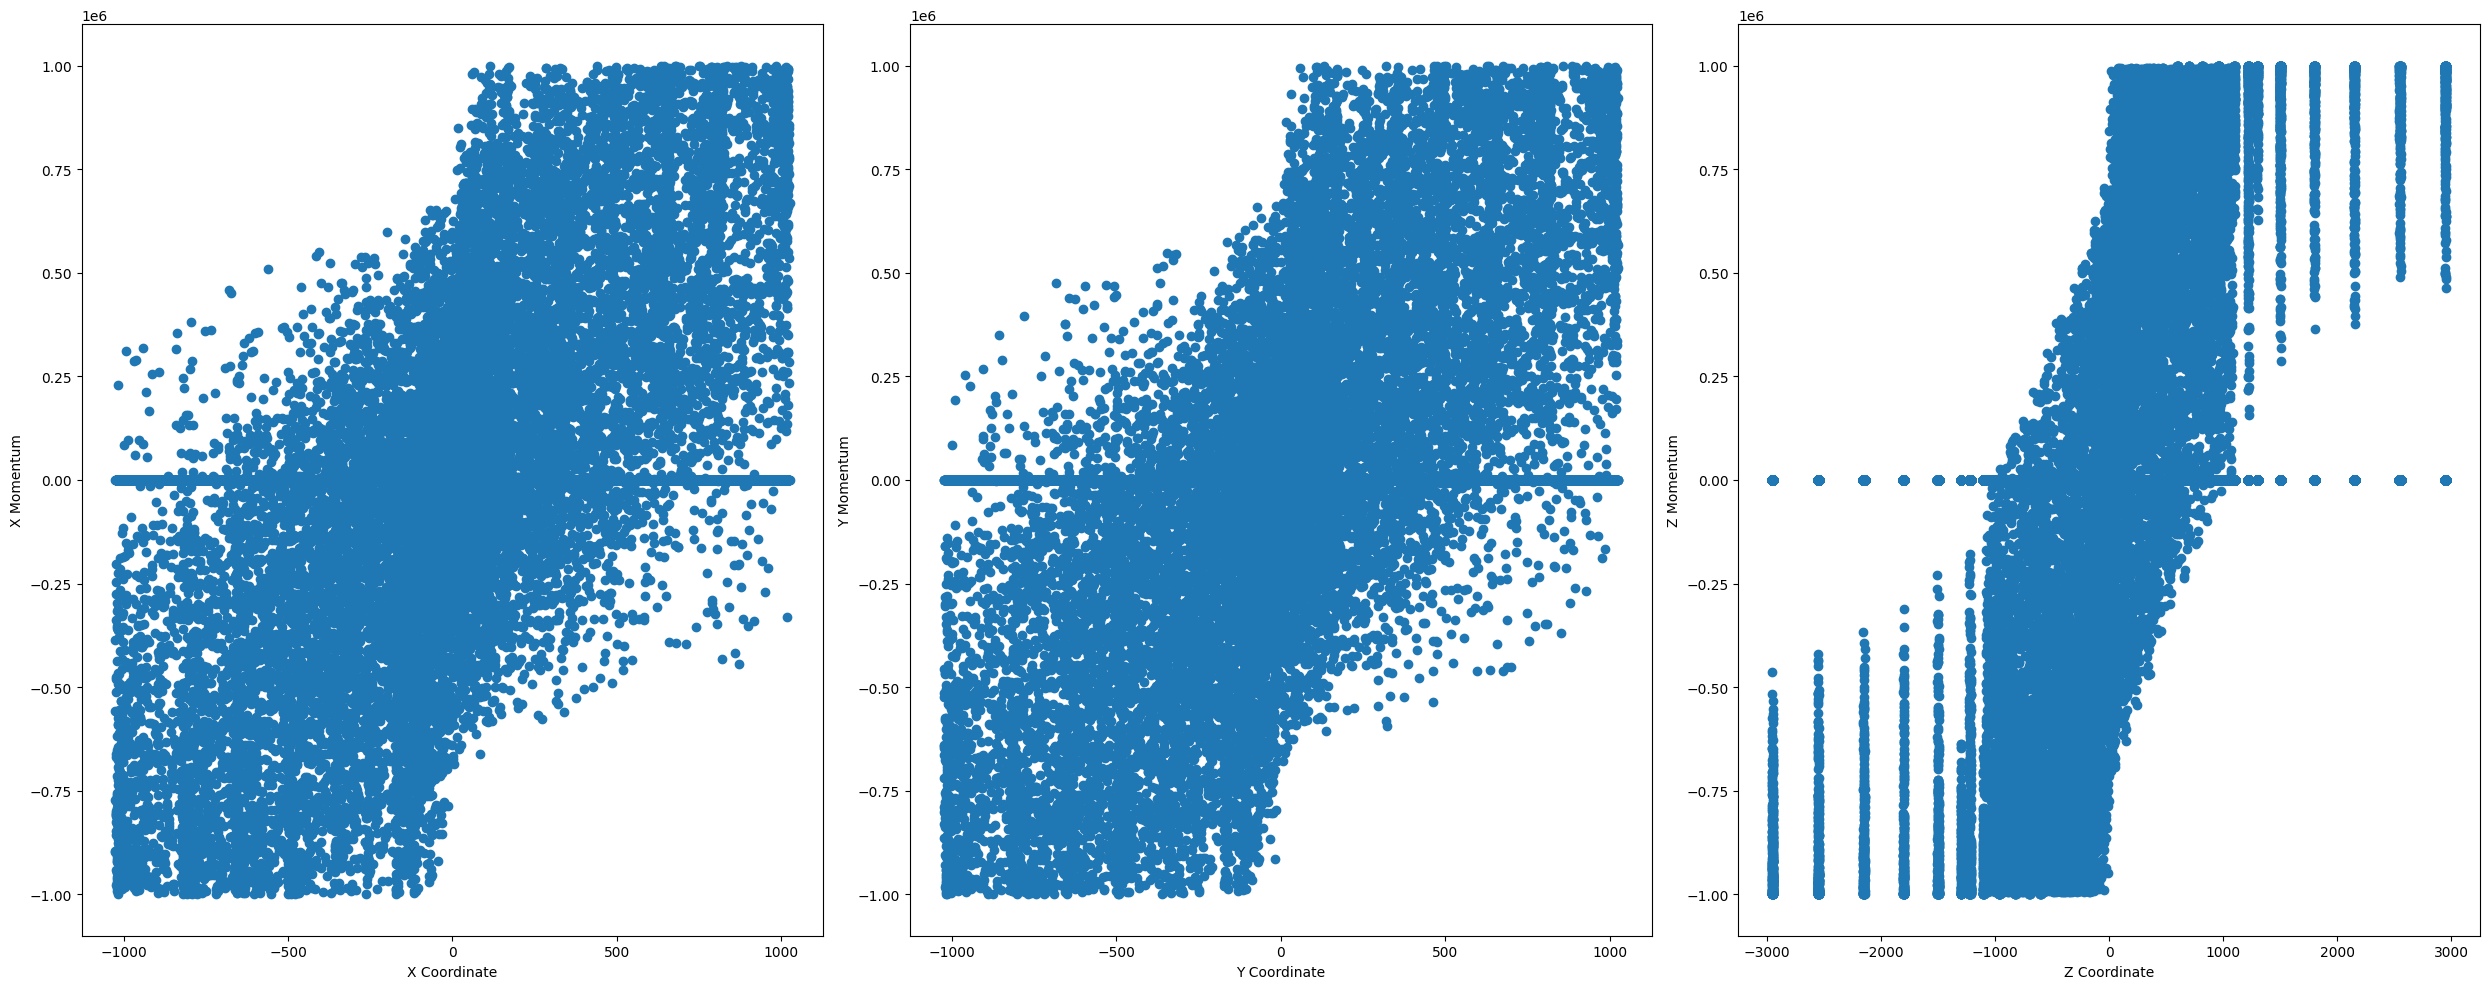

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))
ax1.scatter(x=truth['tx'], y=truth['tpx'])
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('X Momentum')
ax2.scatter(x=truth['ty'], y=truth['tpy'])
ax2.set_xlabel('Y Coordinate')
ax2.set_ylabel('Y Momentum')
ax3.scatter(x=truth['tz'], y=truth['tpz'])
ax3.set_xlabel('Z Coordinate')
ax3.set_ylabel('Z Momentum')

plt.tight_layout()
plt.show()

In [17]:
truth[(truth['tpx'] > -0.01) & (truth['tpx'] < 0.01)].shape[0]

1759

In [18]:
truth[(truth['tpy'] > -0.01) & (truth['tpy'] < 0.01)].shape[0]

1782

In [19]:
truth[(truth['tpz'] > -0.01) & (truth['tpz'] < 0.01)].shape[0]

1033

The relationship between these seems to be linear, hence the larger positive correlation values in the heatmap. However, there are observable lines at momentum = 0. I would assume that this exists because particles eventually slow down and stop. We can see from the data filtering above that there are a handful of points between ± 0.01. While there are no values at 0, which means that no particles actually ever stop moving during an event, some particles get very close.

### 📊 **The Hits CSV File**
The hits data represents one hit by a particle on a detector.

 - **hit_id**: numerical identifier of the hit inside the event.
 - **x, y, z**: measured x, y, z position (in millimeter) of the hit in
global coordinates.
 - **volume_id**: numerical identifier of the detector group.
 - **layer_id**: numerical identifier of the detector layer inside the
group.
 - **module_id**: numerical identifier of the detector module inside
the layer.

The volume, layer, and module can be found using the coordinates, but are given to us. Here is a image to better understand the volumes and layers.

<div align="center">
    <img src="https://asalzbur.web.cern.ch/asalzbur/work/tml/Detector.png" width="500"/>
    <p><b>Figure 2.</b> TrackML Detector Layout</p>
</div>

In [20]:
hits.describe()

hit_id              x              y              z  \
count  120939.00000  120939.000000  120939.000000  120939.000000   
mean    60470.00000      -1.769455       4.751039      -2.315056   
std     34912.22644     305.715118     305.173096    1061.912476   
min         1.00000   -1024.839966   -1025.109985   -2955.500000   
25%     30235.50000    -100.146000     -95.896503    -655.799988   
50%     60470.00000      -1.651340       1.005920      -1.800000   
75%     90704.50000      97.267651     103.224003     655.799988   
max    120939.00000    1025.329956    1024.849976    2955.500000   

           volume_id       layer_id      module_id  
count  120939.000000  120939.000000  120939.000000  
mean       10.921564       5.918389     371.969117  
std         3.365705       3.407428     529.032206  
min         7.000000       2.000000       1.000000  
25%         8.000000       4.000000      60.000000  
50%         9.000000       6.000000     119.000000  
75%        13.000000       8.000000     490.000000  
max        18.000000      14.000000    3192.000000

In [21]:
hits.nunique()

hit_id       120939
x            117316
y            117045
z             38020
volume_id         9
layer_id          7
module_id      3028
dtype: int64

For the volumes, there are only 9 possible values which are represented by the larger font numbers within Figure 2. For the layers, there are only 7 possible values which are represented by the smaller font numbers within Figure 2. Module ranges from 1 to 3,192. Not every possible value within those number for module appears in the data, as there are only 3,028 unique values of module_id. 

X and Y seem to range between ±1025 and Z ranges between ±2955.5. They all have a mean near zero, which leads me to assume they have normal distributions of data. The visualization below confirms this.

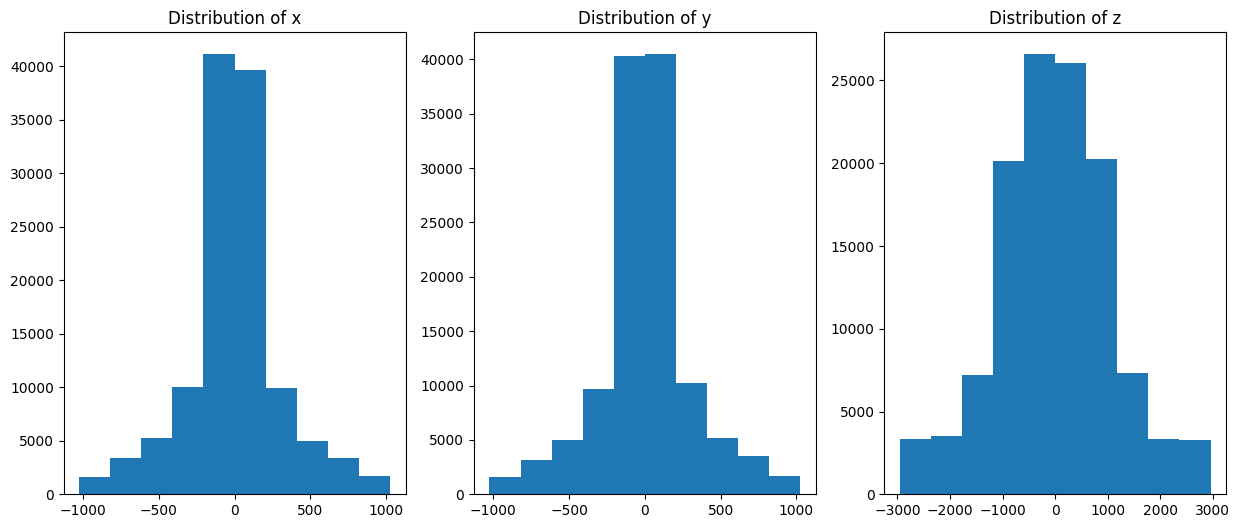

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
ax1.hist(hits['x'])
ax1.set_title('Distribution of x')
ax2.hist(hits['y'])
ax2.set_title('Distribution of y')
ax3.hist(hits['z'])
ax3.set_title('Distribution of z')
plt.show()

## Descriptive Analysis & Visualizations

### 🔹 Detector Geometry

As for the geometry of the detector, the Kaggle competion thankfully gives us some insight. The overall detector is built from rectangular and trapezoidal slabs of silicon (see Figure 3 below).

<div align="center">
    <img src="https://asalzbur.web.cern.ch/asalzbur/work/tml/ModuleTypes.png" width="500"/>
    <p><b>Figure 3.</b> TrackML Module Shapes</p>
</div>

The silicon slabs are grouped in two configurations within the detector, cylinders and discs. These arrangments of slabs into cylinders and discs represent volumes—described by volume_id in the hits dataset. Within each volume, the silicon slabs are further grouped into layers—described by layer_id in the hits dataset—which can then contain modules. Modules—described by module_id in the hits dataset—are the smallest possible geometric configuration (aka the rectangular and trapezoidal slabs that the detector is built with).

Volumes 7, 8, 9, 13, and 17 are all built from rectangular modules. These volumes are the pixel detector and cylindrical barrels. The other volumes—volumes 12, 14, 16, and 18—use trapezoidal modules to make up disc shapes.

Let's do some digging into the volumes and layers. Then, let's visualize some of the geometry of the coordinates by themselves, and then by volume and layer IDs.

🔹 First let's look at the layers that show up in each volume, and the number of hits in each.

In [23]:
volume_group = hits.groupby(['volume_id', 'layer_id'])['hit_id'].agg('count').reset_index().rename(columns={'hit_id': 'num_hits'})
volume_group

volume_id  layer_id  num_hits
0           7         2      1449
1           7         4      1767
2           7         6      2165
3           7         8      2553
4           7        10      2887
5           7        12      3028
6           7        14      3024
7           8         2      8892
8           8         4      7484
9           8         6      6672
10          8         8      6124
11          9         2      3013
12          9         4      3052
13          9         6      2980
14          9         8      2558
15          9        10      2184
16          9        12      1845
17          9        14      1554
18         12         2      1185
19         12         4      1207
20         12         6      1292
21         12         8      1279
22         12        10      1434
23         12        12      1534
24         13         2      7171
25         13         4      6800
26         13         6      6303
27         13         8      5716
28         14         2      1414
29         14         4      1368
30         14         6      1285
31         14         8      1195
32         14        10      1175
33         14        12      1148
34         16         2       457
35         16         4       489
36         16         6       476
37         16         8       446
38         16        10       488
39         16        12       559
40         17         2      5237
41         17         4      5119
42         18         2       635
43         18         4       482
44         18         6       418
45         18         8       415
46         18        10       480
47         18        12       501

Only volumes 7 and 9 use all 7 layers. Volumes 12, 14, 16, and 18 use up to layer 12 (6 layers). Volumes 8 and 13 use up to layer 8 (4 layers), and volume 17 only uses up to layer 4 (2 layers). We can confirm this behavior with Figure 2, which shows the layers in each volume. 

One thing I notice from this is that the number of hits in 16 and 18 are pretty low, while the number of hits in 8 and 13 are pretty high. Let's look into this a bit more.

🔹 Now, let's look at the total number of hits per volume.

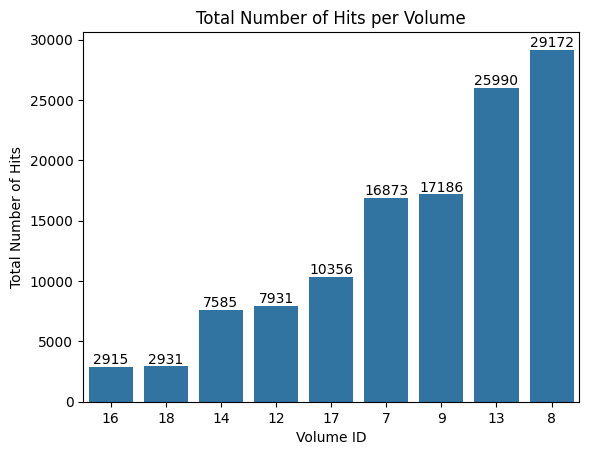

In [24]:
volume_hits_sum = volume_group.groupby('volume_id')['num_hits'].sum().reset_index().rename(columns={'num_hits': 'total_vol_hits'}).sort_values('total_vol_hits')
ax = sns.barplot(data=volume_group, x='volume_id', y='num_hits', order=volume_hits_sum['volume_id'], estimator='sum', errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlabel('Volume ID')
ax.set_ylabel('Total Number of Hits')
ax.set_title('Total Number of Hits per Volume')
plt.show()

In [25]:
print('Differences of total hit counts by volumes in descending order of total hits per volume.')
print(volume_hits_sum[volume_hits_sum['volume_id'] == 16]['total_vol_hits'].iloc[0] - volume_hits_sum[volume_hits_sum['volume_id'] == 18]['total_vol_hits'].iloc[0], ',',
      volume_hits_sum[volume_hits_sum['volume_id'] == 18]['total_vol_hits'].iloc[0] - volume_hits_sum[volume_hits_sum['volume_id'] == 14]['total_vol_hits'].iloc[0], ',', 
      volume_hits_sum[volume_hits_sum['volume_id'] == 14]['total_vol_hits'].iloc[0] - volume_hits_sum[volume_hits_sum['volume_id'] == 12]['total_vol_hits'].iloc[0], ',', 
      volume_hits_sum[volume_hits_sum['volume_id'] == 12]['total_vol_hits'].iloc[0] - volume_hits_sum[volume_hits_sum['volume_id'] == 17]['total_vol_hits'].iloc[0], ',', 
      volume_hits_sum[volume_hits_sum['volume_id'] == 17]['total_vol_hits'].iloc[0] - volume_hits_sum[volume_hits_sum['volume_id'] == 7]['total_vol_hits'].iloc[0], ',', 
      volume_hits_sum[volume_hits_sum['volume_id'] == 7]['total_vol_hits'].iloc[0] - volume_hits_sum[volume_hits_sum['volume_id'] == 9]['total_vol_hits'].iloc[0], ',', 
      volume_hits_sum[volume_hits_sum['volume_id'] == 9]['total_vol_hits'].iloc[0] - volume_hits_sum[volume_hits_sum['volume_id'] == 13]['total_vol_hits'].iloc[0], ',', 
      volume_hits_sum[volume_hits_sum['volume_id'] == 13]['total_vol_hits'].iloc[0] - volume_hits_sum[volume_hits_sum['volume_id'] == 8]['total_vol_hits'].iloc[0])

Differences of total hit counts by volumes in descending order of total hits per volume.
-16 , -4654 , -346 , -2425 , -6517 , -313 , -8804 , -3182


Volumes 16 and 18, which have the least amount of hits counts, have a seemingly signifigantly small difference between their total hit counts. Referring to Figure 2, volumes 16 and 18 are in the upper corners of the figure, with the most extreme values of r and z (16 has the highest values of r and lowest values of z, 18 has the highest values of r and highest values of z). If we assume the particle originates from r = 0, z = 0, then these volumes would be two of the furthest volumes, and thus harder to reach. If we keep this assumption that, from Figure 2, the proximity to 0, 0 is directly coorelated with the number of hits for that volume, then we can also make the assumption that volume 8 will have the highest number of hits. We can see from the data above that this is true, with volume 8 having a total of about 29,000 hits.

Some assumptions we may be able to make about this are:
 1) It is harder to reach the outer corner volumes. Particles that reach those volumes may need more initial momentum than others.
 2) OR It is completely random if the particle ends up in the outer corner volumes.

We can also recall from earlier discussion about the volumes that volumes 7, 8, 9, 13, and 17 are cylindrical while volumes 12, 14, 16, and 18 are discs. We can see here that the cylindrical volumes seem to record more hits than the disc shaped volumes.

Let's look at some 3-Dimensional visualizations of each volume.

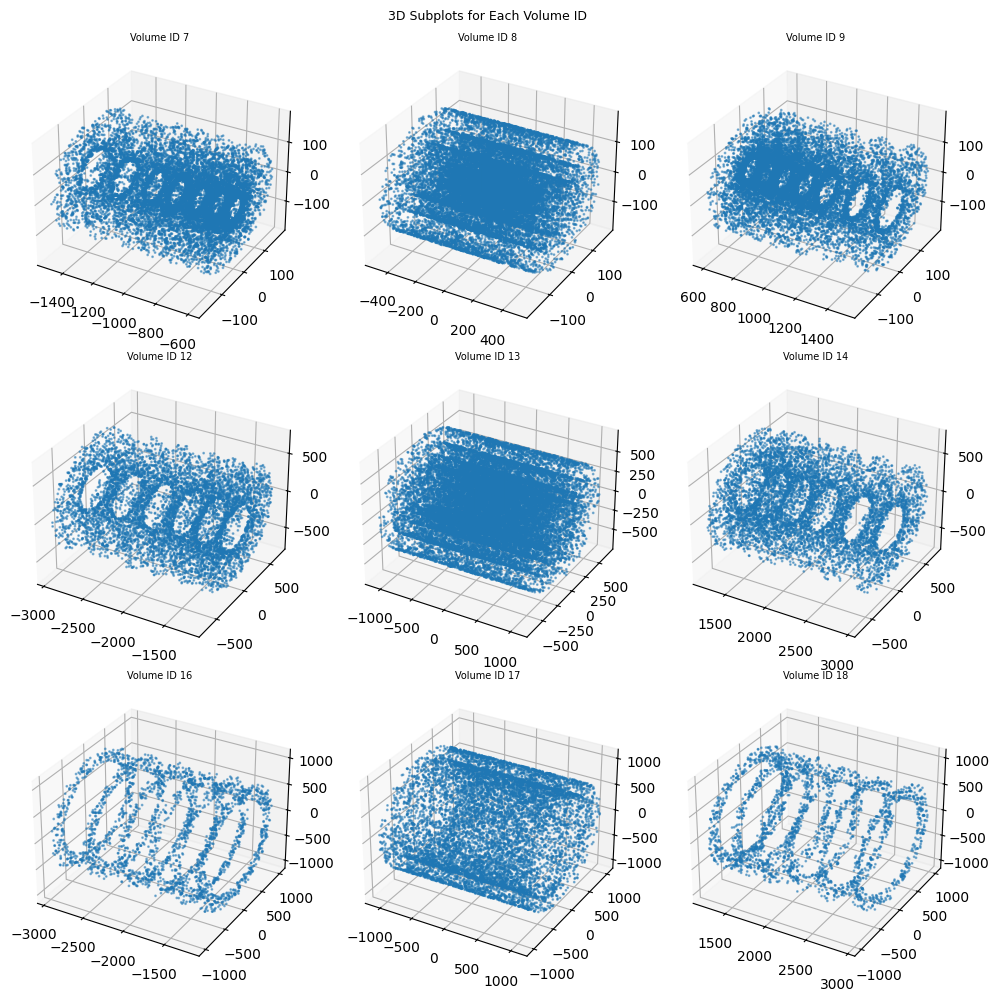

In [26]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10, 10), subplot_kw=dict(projection="3d"))
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

volumes = hits['volume_id'].unique()
for vol, ax in zip(volumes, axes):
    v = hits[hits.volume_id == vol]
    ax.scatter(v.z, v.x, v.y, s=1, alpha=0.5)
    ax.set_title(f'Volume ID {vol}', fontsize=7)

fig.suptitle('3D Subplots for Each Volume ID', fontsize=9)
plt.tight_layout()
plt.show()

While 8, 13, and 17 certainly look cylindrical, volumes 7 and 9 seem more disc-like. However, that could be because these two are specifically pixel detectors.

Let's will explore the assumption that the further a volume is from r=0 z=0, the more momentum the particle needs to have to hit detectors in that volume. We will do this by looking into the distribution of particle charges and momentum for each volume, as well as a heatmap plot to see if anything has a particularly high correlation.

In [27]:
particle_vols = pd.merge(truth, hits.drop(columns=['x', 'y', 'z']), on='hit_id')

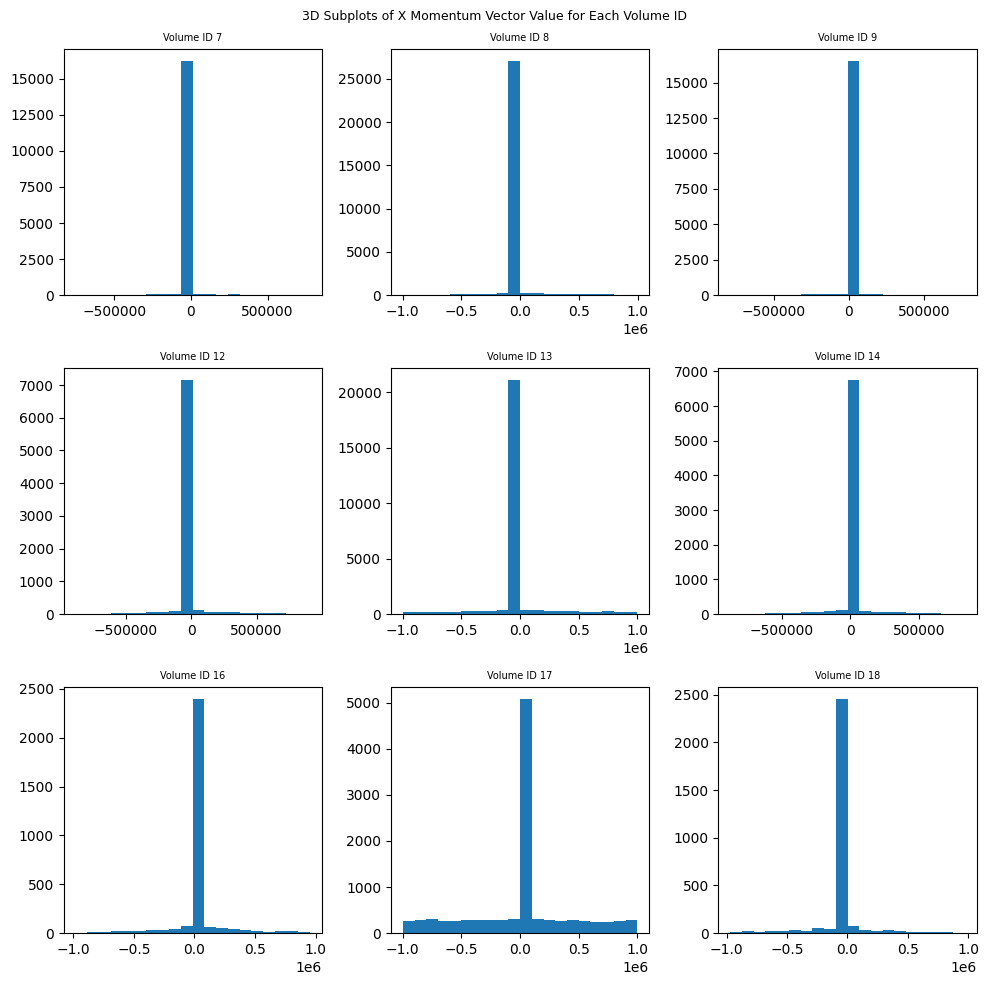

In [28]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10, 10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

volumes = particle_vols['volume_id'].unique()
for vol, ax in zip(volumes, axes):
    v = particle_vols[particle_vols.volume_id == vol]
    ax.hist(v['tpx'], bins=20)
    ax.set_title(f'Volume ID {vol}', fontsize=7)

fig.suptitle('3D Subplots of X Momentum Vector Value for Each Volume ID', fontsize=9)
plt.tight_layout()
plt.show()

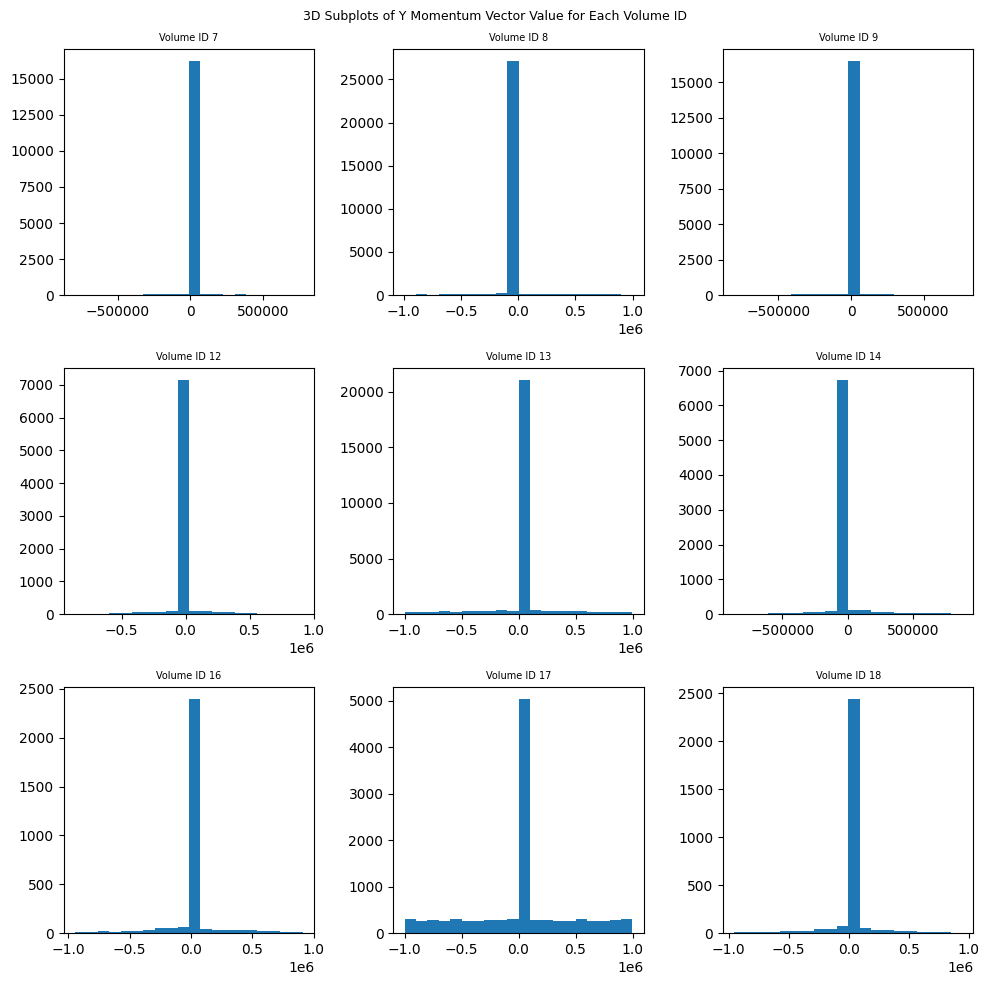

In [29]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10, 10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

volumes = particle_vols['volume_id'].unique()
for vol, ax in zip(volumes, axes):
    v = particle_vols[particle_vols.volume_id == vol]
    ax.hist(v['tpy'], bins=20)
    ax.set_title(f'Volume ID {vol}', fontsize=7)

fig.suptitle('3D Subplots of Y Momentum Vector Value for Each Volume ID', fontsize=9)
plt.tight_layout()
plt.show()

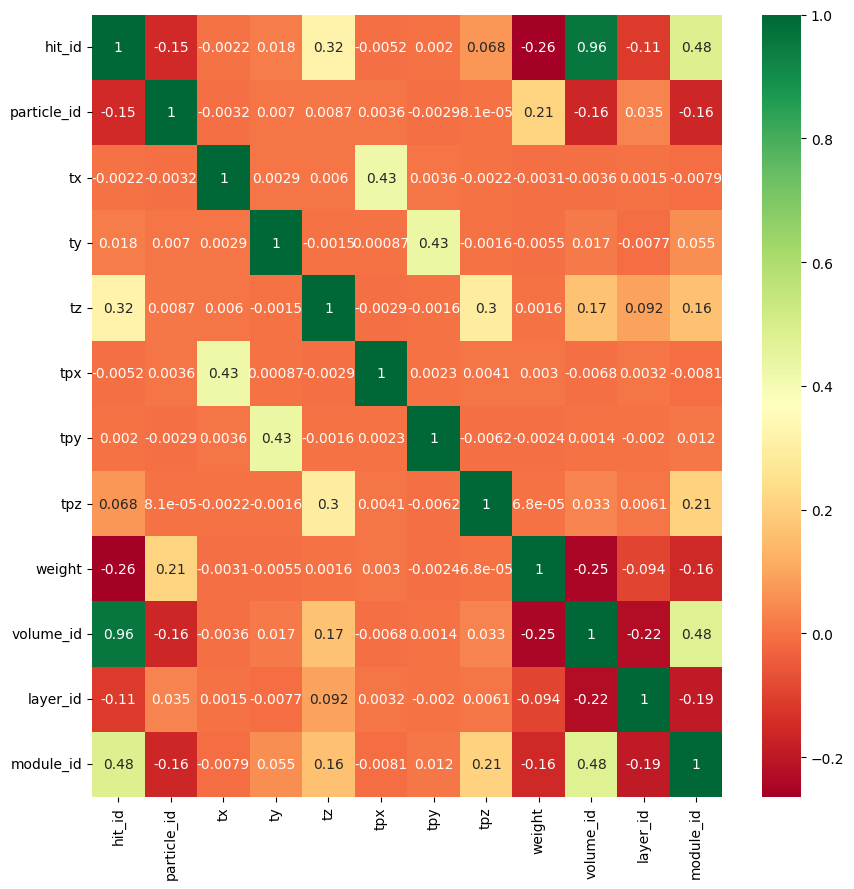

In [30]:
plt.figure(figsize=(9, 9))
sns.heatmap(particle_vols.corr(), annot=True, cmap="RdYlGn")
plt.tight_layout()
plt.show()

We can see from the plots that volumes 16, 17, and 18, which are the furthest volumes from the origin point, do have distributions of momentum that have higher values and therefore higher spread. However, this observation is not statistically signifigant as we can see from the heatmap. This is probably because while this does contain more high absolute values of momentum than the other volumes, there is still that extremely large spike as the momentum reaches zero. With that spike, most distributions will look the same and any statistical signifigance will not be very apparent.

🔹 Now, let's look at the modules in each layer.

In [31]:
num_modules_per_vol_layer_group = hits.groupby(['volume_id', 'layer_id'])['module_id'].agg('count').reset_index().rename(columns={'module_id': 'num_modules_vol_layer'})
num_modules_vol_group = hits.groupby(['volume_id'])['module_id'].agg('count').reset_index().rename(columns={'module_id': 'num_modules_vol'})
num_modules_layer_group = hits.groupby(['layer_id'])['module_id'].agg('count').reset_index().rename(columns={'module_id': 'num_modules_layer'})

num_modules_data = None
# Merge the vol module group
num_modules_data = pd.merge(volume_group, num_modules_vol_group, on='volume_id')
# Merge to layer module group
num_modules_data = pd.merge(num_modules_data, num_modules_layer_group, on='layer_id')
# Merge vol, layer module group
num_modules_data = pd.merge(num_modules_data, num_modules_per_vol_layer_group, on=['volume_id', 'layer_id'])

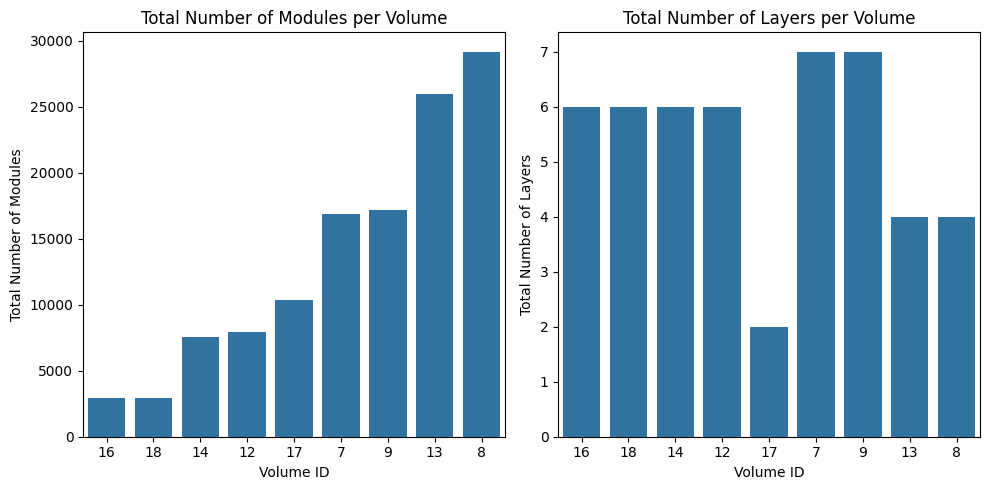

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot number of hits per volume
sns.barplot(data=num_modules_data, x='volume_id', y='num_modules_vol', order=volume_hits_sum['volume_id'], errorbar=None, ax=ax1)
ax1.bar_label(ax.containers[0], fontsize=10)
ax1.set_xlabel('Volume ID')
ax1.set_ylabel('Total Number of Modules')
ax1.set_title('Total Number of Modules per Volume')

# Plot number of layers per volume
layers_count = num_modules_data.groupby('volume_id')['layer_id'].count().reset_index().rename(columns={'layer_id': 'layer_count'}).sort_values('layer_count')
sns.barplot(data=layers_count, x='volume_id', y='layer_count', order=volume_hits_sum['volume_id'], errorbar=None, ax=ax2)
ax2.set_xlabel('Volume ID')
ax2.set_ylabel('Total Number of Layers')
ax2.set_title('Total Number of Layers per Volume')

plt.tight_layout()
plt.show()

We can see from this that there is not a correlation between number of modules and number of layers. That means that even though there may be more layers in a volume, that does not mean there are more modules.

We can also see that some volumes have a LOT higher number of modules when compared to the others, with volumes 13 and 8 having more than 25,000 modules each while volumes 16 and 18 have about 3,000 each. 

This may be an obvious assumption, but I'm sure that if there are less modules (meaning less things able to detect hits), then there are also less hits. Let's look at this with a heatmap.

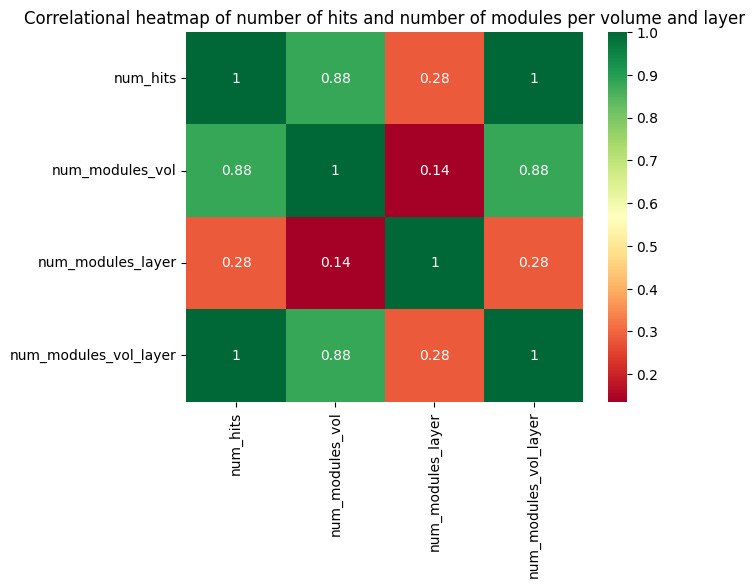

In [33]:
sns.heatmap(num_modules_data.drop(columns=['volume_id', 'layer_id']).corr(), annot=True, cmap="RdYlGn")
plt.title('Correlational heatmap of number of hits and number of modules per volume and layer')
plt.show()

Sure enough, there is a high positive correlation between number of modules in a volume and number of hits. The layers do not have a high correlation because the layer id can be the same amongst volumes. Therefore, unless compared with the volume as well, the layer is not unique enough to display a relationship (which it shouldn't)!

🔹 Let's look at some more 3D plots for fun.

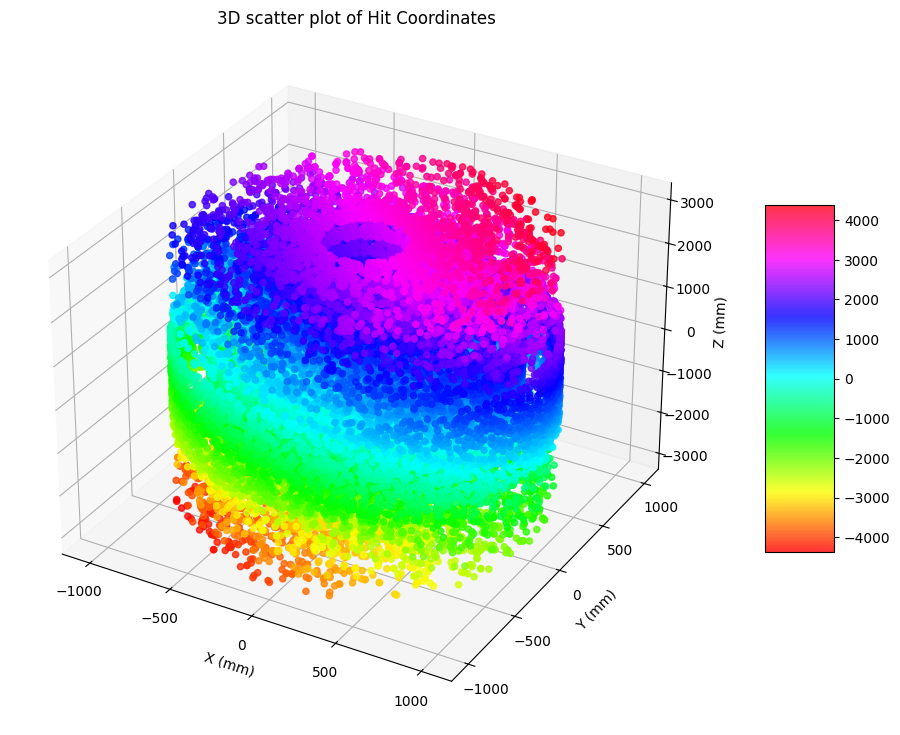

In [34]:
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

# Creating plot
sctt = ax.scatter3D(hits.x, hits.y, hits.z,
                    alpha = 0.8,
                    c = (hits.x + hits.y + hits.z), 
                    cmap = plt.get_cmap('hsv'), 
                    marker ='o')
 
plt.title("3D scatter plot of Hit Coordinates")
ax.set_xlabel('X (mm)') 
ax.set_ylabel('Y (mm)') 
ax.set_zlabel('Z (mm)')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

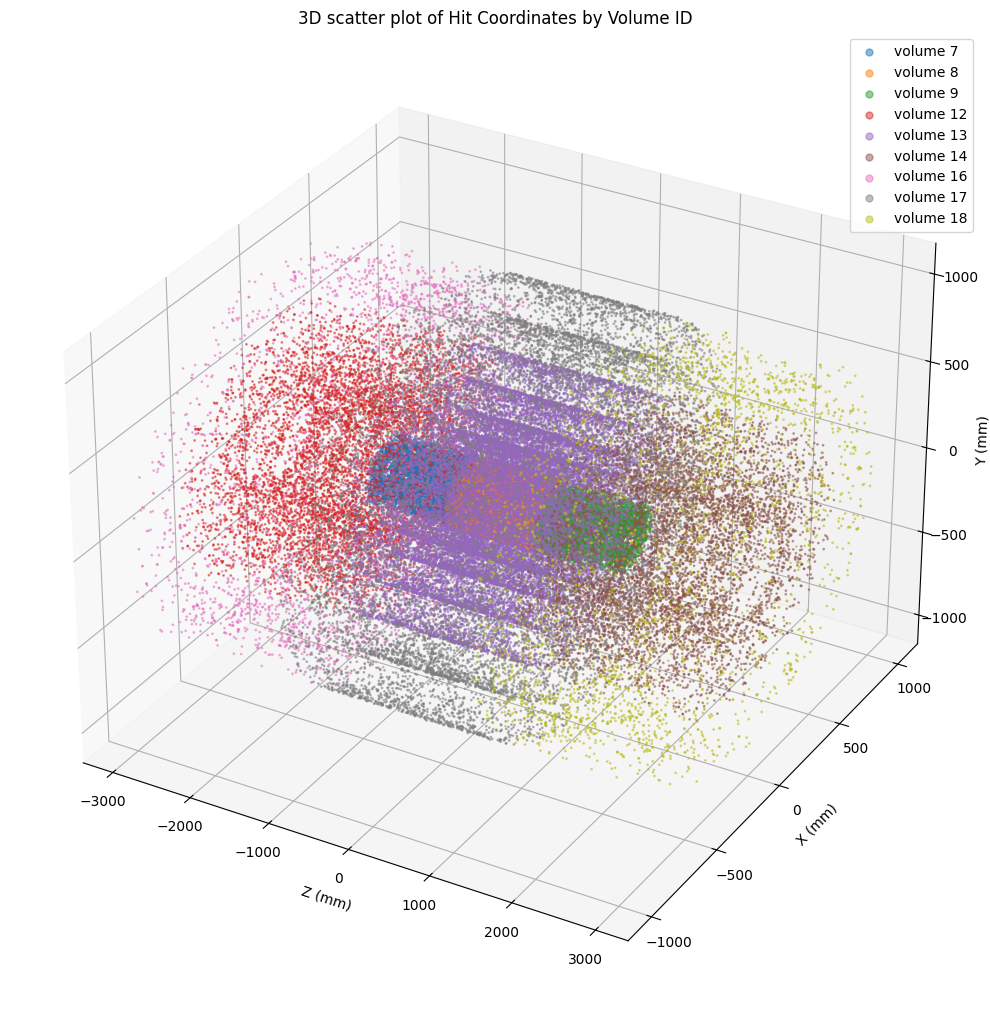

In [35]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121,projection='3d')
# ax2 = fig.add_subplot(122,projection='3d')

volumes = hits.volume_id.unique()
# layers = hits.layer_id.unique()

for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax1.scatter(v.z, v.x, v.y, s=1, label=f'volume {volume}', alpha=0.5)

# for layer in layers:
#     l = hits[hits.layer_id == layer]
#     ax2.scatter(l.z, l.x, l.y, s=1, label=f'layer {layer}', alpha=0.5)

ax1.set_xlabel('Z (mm)')
ax1.set_ylabel('X (mm)')
ax1.set_zlabel('Y (mm)')
ax1.set_title('3D scatter plot of Hit Coordinates by Volume ID')
# ax2.set_xlabel('Z (mm)')
# ax2.set_ylabel('X (mm)')
# ax2.set_zlabel('Y (mm)')
# ax2.set_title('3D scatter plot of Hit Coordinates by Layer ID')
ax1.legend(markerscale=5)
# ax2.legend(markerscale=5)
plt.tight_layout()
plt.show()

## 🔷 The Models

Now that we have explored our data, let's review our task. The overall goal of this project is to map each hit to a unique track. We will create the track IDs. We can use all four of the CSV files to train our model. However, we need to keep in mind that our model can only test with cells and hits data. From our cell file, we get the hit ID, the ID corresponding to the module that was hit, and the charge deposited by the particle hit. From hits we get the hit ID, the position of the hit in x, y, and z coordinates, and the volume, layer, and module that was hit.

We do not have a label in our data for our target (which is track), so traditional supervised machine learning techniques that take in X data of descriptive labels and Y data of a target label will not be ideal. Instead, we will have to use unsupervised or semi-supervised learning techniques. 

Some unsupervised techniques include clustering, k nearest neighbors, and neural networks. There are many types of clustering and neural networks, and many different techniques that can be used. Some clustering techniques include density, distribution, centroid, and hierarchical based algorithms. Two algorithms I would like to explore are K-means clustering, which is centroid-based, and DBSCAN, which is density-based. The latter is a popular solution for this competition on Kaggle.

It is also possible to go through the data ourselves and try to connect some hits to tracks. This way, we can create some track_id labels, train our model on that with supervised learning techniques, and then use unsupervised techniques to continue training our data. We can do this using the truth and particle CSV files to track a unique particle ID to different hit IDs in the truth file. The assumption is that each particle will follow its own track, so we can add a unique track_id value to each unique particle ID, then map that back onto the hits file using hit ID. After assigning a track_id to a subset of data, we can pre-train our model with those labels. Then, we can continue training without the labels (which includes omitting the track ID). This way, we will not have to use the particle and truth CSV files in our final training and ultimately, testing.

For semi-supervised learning, we have two options:
1) A pseudolabel method, which will first train a NN on our labeled data, then predict labels for the unlabeled data, and put all of it (labeled and pseudo-labeled) into the NN to train on. The image below describes this process.

<div align="center">
    <img src="https://lh4.googleusercontent.com/ObRTkjqqlsR8lb-dQJ0ZRonjKoD5t4_yFSRpJHOvg0y-gEm_wsPqvYVpBHo9LpfxGi4hwkRimpGcEoodQGjXiYFa-ZHYUuS5g9PmwHXWRkWfjnQj0N-J52TGpC9nmJXb_uD3HtJE2p__71uTeOKjqwdtfICDyXI2v5jheswO0NQMN-Trk8pmwsqi4sK_1w" width="300"/>
    <p><b>Figure 4.</b> Pseudo-Labeling Visualization</p>
</div>

2) A label propogation method, which works with graphs. Unlabeled and labeled data points are all put into a graph. Unlabeled data points are then labeled based on their proximity to the closest labeled point in the graph. The image below describes this process. 

<div align="center">
    <img src="https://lh4.googleusercontent.com/7Sx9pN_BkwcXaQWJ7WHgpaAWRyFR-lOAZk-jlOpBIMCZpfIJKHiGXfDLXoVPhvR6_XFfiamg6t3L233r9mxZseP5a8XaIT_HM5BiYNR8Yf1RJIyWaf5MUkeBpm6tOvKn4t7JYzbsaX4_VtCxHN2EdeAXlsFzya-EUaaftsMKSgy3V4VBUfamgvdyfevarA" width="500"/>
    <p><b>Figure 5.</b> Label Propogation Visualization</p>
</div>

<small>Examples and images come from Potrimba, 2022.</small>

Let's try out some semi-supervised techniques, then let's try a completely unsupervised technique and compare.

### 🔹 Semi-Supervised Techniques

#### 🧩 Labeling Track IDs

For this event, there are 12,263 unique particles. There are 10,565 particles with one or more hit. We can track these particles' hits using their unique IDs and the truth CSV file. Then, we can assign a unique track_id to each particle in the truth file. Once we have a track_id, we can add the column to the hits CSV file on hit_id so each hit is assigned to a track.

Because we are using hits to detail tracks, any particle with no hit will not have a track and therefore will not be included in this data. Our resulting dataset also shouldn't have any tracks with more than 19 hits, as that is the maximum number of hits for the particles. We'll check if any track IDs have more than 19 hit IDs.

Also something important to remember, our particle IDs can have a value of 0. A value of 0 means that the hit did not originate from a reconstructible particle but, for example, from detector noise. We will exclude any instance with a particle ID of 0.

In [36]:
# Group by particle ID and add a unique track ID based on each particle
truth['track_id'] = truth.groupby('particle_id').ngroup()

In [37]:
truth.head(1)

hit_id  particle_id         tx       ty      tz       tpx       tpy  \
0       1            0 -64.411598 -7.16412 -1502.5  250710.0 -149908.0   

        tpz  weight  track_id  
0 -956385.0     0.0         0

In [38]:
# Check for tracks with more than 19 hits
track_counts = truth.groupby('track_id').count().reset_index()
tracks_19_plus_rows = track_counts[track_counts['hit_id'] > 19]
tracks_19_plus_rows

track_id  hit_id  particle_id     tx     ty     tz    tpx    tpy    tpz  \
0         0   17634        17634  17634  17634  17634  17634  17634  17634   

   weight  
0   17634

In [39]:
truth[truth['particle_id'] == 0].head(1)

hit_id  particle_id         tx       ty      tz       tpx       tpy  \
0       1            0 -64.411598 -7.16412 -1502.5  250710.0 -149908.0   

        tpz  weight  track_id  
0 -956385.0     0.0         0

There are 17,634 instances with particle ID of 0. The instances with particle ID of 0 have a track ID of 0. After merging the track IDs to the hits dataset, we will drop all instances that have a track ID of 0.

Now that we have our encoded labels, let's merge them with the hits file on hit_id and drop any instances with track ID of 0.

In [40]:
# Merge track ID with hits track
hits_track = pd.merge(hits, truth[['hit_id', 'track_id']], on='hit_id')
# Only include instances if track id is not 0
hits_track = hits_track[hits_track['track_id'] != 0]
hits_track

hit_id           x          y       z  volume_id  layer_id  module_id  \
1            2  -55.336102   0.635342 -1502.5          7         2          1   
3            4  -96.109100  -8.241030 -1502.5          7         2          1   
4            5  -62.673599  -9.371200 -1502.5          7         2          1   
5            6  -57.068699  -8.177770 -1502.5          7         2          1   
6            7  -73.872299  -2.578900 -1502.5          7         2          1   
...        ...         ...        ...     ...        ...       ...        ...   
120934  120935 -763.862976  51.569401  2944.5         18        12         97   
120935  120936 -808.705017   3.459260  2944.5         18        12         97   
120936  120937 -982.935974  41.460899  2952.5         18        12         98   
120937  120938 -942.698975  18.489100  2952.5         18        12         98   
120938  120939 -922.890015   2.092850  2952.5         18        12         98   

        track_id  
1            477  
3           3556  
4           4811  
5           1384  
6          10496  
...          ...  
120934      5170  
120935      9817  
120936      3231  
120937      4525  
120938      3193  

[103305 rows x 8 columns]

Let's visualize some of these tracks.

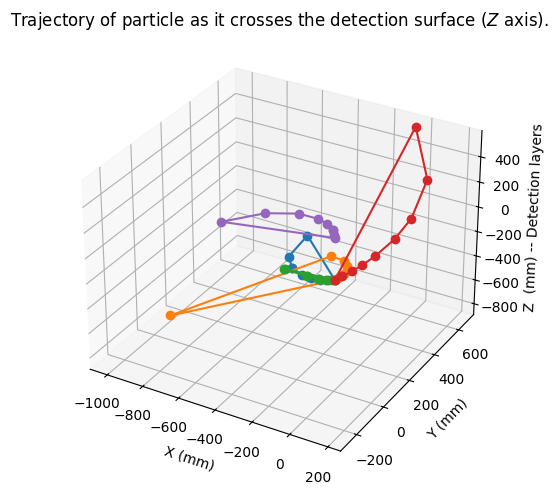

In [41]:
# Initialize plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
# Get a track
# NOTE: It is better to group visualizations by same number of hits
particle_ids = np.array(particles[particles.nhits == 8].head(5)['particle_id'])
track_ids = truth[truth['particle_id'].isin(particle_ids)]['track_id']
track_ids = track_ids.unique()
for track_id in track_ids:
    track = hits_track[hits_track.track_id == track_id]
    # Map a hit ID from track back to truth to get particle ID
    particleid = truth[truth.track_id == track_id]['particle_id'].iloc[0]
    # Get the particle initial position
    particle = particles[particles.particle_id == particleid].rename(columns={'vx': 'x', 'vy': 'y', 'vz': 'z'})
    # Get all hit coordinates of particle from both track1 and particle1 (which includes initial position)
    coors = pd.concat([track[['x', 'y', 'z']], particle[['x', 'y', 'z']]])
    ax.plot(
        xs=coors.x,
        ys=coors.y,
        zs=coors.z, marker='o')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
plt.title('Trajectory of particle as it crosses the detection surface ($Z$ axis).')
plt.tight_layout()
plt.show()

We can see five particle tracks above as they cross the detectors surface, each represented by a different color. Each dot on a track is a hit, denoted by a hit_id in the data.

Now that we have the predictive label, let's get to the semi-supervised learning.

#### 🧩 Semi-Supervised Learning with Label Propogation

First, let's test some supervised machine learning algorithms to determine which one performs best. Whichever model performs best will be used in the semi-supervised learning technique.

We will use the hits CSV file for our data in these models. We first will split into X and y, which will be the hit columns WITHOUT target ID, and target ID as our predictive column. Then, we will further split it using train test split. Then, we will further filter the data so the train data has labels and the test data does not.

In [43]:
# define dataset
TARGET = ['track_id']
X, y = hits_track.drop(columns=TARGET, axis=1), hits_track[TARGET]

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [44]:
# Split into subsets to minimize runtime for label propogation
X_train_small = X_train.iloc[:8000]
y_train_small = y_train.iloc[:8000]
print(X_train_small.shape, y_train_small.shape)

(8000, 7) (8000, 1)


Now that we have our data ready to use, we will try a suite of machine learning models. These include logistic regression, random forest, K nearest neighbors, decision tree, gaussian naive bayes, and ADA boost. We will record their accuracy scores to compare against one another.

🟢 Logisitic Regression

In [45]:
# define model
log_reg_model = LogisticRegression()
# fit model on labeled dataset
log_reg_model.fit(X_train_small, y_train_small)
# make predictions on hold out test set
log_reg_y_pred = log_reg_model.predict(X_test)

In [46]:
lr_accuracy = accuracy_score(y_test, log_reg_y_pred)
lr_precision = precision_score(y_test, log_reg_y_pred, average='weighted')
lr_recall = recall_score(y_test, log_reg_y_pred, average='weighted')
print(f'Accuracy: {round(lr_accuracy*100, 3)}% Precision: {round(lr_precision*100, 3)}% Recall: {round(lr_recall*100, 3)}%')

Accuracy: 0.102% Precision: 0.003% Recall: 0.102%


🟢 Random Forest

In [47]:
# define model
rand_forest_model = RandomForestClassifier()
# fit model on labeled dataset
rand_forest_model.fit(X_train_small, y_train_small)
# make predictions on hold out test set
rand_forest_y_pred = rand_forest_model.predict(X_test)

In [48]:
rf_accuracy = accuracy_score(y_test, rand_forest_y_pred)
rf_precision = precision_score(y_test, rand_forest_y_pred, average='weighted')
rf_recall = recall_score(y_test, rand_forest_y_pred, average='weighted')
print(f'Accuracy: {round(rf_accuracy*100, 3)}% Precision: {round(rf_precision*100, 3)}% Recall: {round(rf_recall*100, 3)}%')

Accuracy: 2.12% Precision: 1.739% Recall: 2.12%


🟢 K Nearest Neighbors

In [49]:
# define model
knn_model = KNeighborsClassifier()
# fit model on labeled dataset
knn_model.fit(X_train_small, y_train_small)
# make predictions on hold out test set
knn_y_pred = knn_model.predict(X_test)

In [50]:
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred, average='weighted')
knn_recall = recall_score(y_test, knn_y_pred, average='weighted')
print(f'Accuracy: {round(knn_accuracy*100, 3)}% Precision: {round(knn_precision*100, 3)}% Recall: {round(knn_recall*100, 3)}%')

Accuracy: 0.482% Precision: 0.16% Recall: 0.482%


🟢 Decision Tree

In [51]:
# define model
dtc_model = DecisionTreeClassifier()
# fit model on labeled dataset
dtc_model.fit(X_train_small, y_train_small)
# make predictions on hold out test set
dtc_y_pred = dtc_model.predict(X_test)

In [52]:
dtc_accuracy = accuracy_score(y_test, dtc_y_pred)
dtc_precision = precision_score(y_test, dtc_y_pred, average='weighted')
dtc_recall = recall_score(y_test, dtc_y_pred, average='weighted')
print(f'Accuracy: {round(dtc_accuracy*100, 3)}% Precision: {round(dtc_precision*100, 3)}% Recall: {round(dtc_recall*100, 3)}%')

Accuracy: 2.514% Precision: 2.046% Recall: 2.514%


In [53]:
# define model
dtc_all_model = DecisionTreeClassifier()
# fit model on labeled dataset
dtc_all_model.fit(X_train, y_train)
# make predictions on hold out test set
dtc_all_y_pred = dtc_all_model.predict(X_test)

In [54]:
dtc_all_accuracy = accuracy_score(y_test, dtc_all_y_pred)
dtc_all_precision = precision_score(y_test, dtc_all_y_pred, average='weighted')
dtc_all_recall = recall_score(y_test, dtc_all_y_pred, average='weighted')
print(f'Accuracy: {round(dtc_all_accuracy*100, 3)}% Precision: {round(dtc_all_precision*100, 3)}% Recall: {round(dtc_all_recall*100, 3)}%')

Accuracy: 9.787% Precision: 11.777% Recall: 9.787%


🟢 Gaussian Naive Bayes

In [55]:
# define model
nb_model = GaussianNB()
# fit model on labeled dataset
nb_model.fit(X_train_small, y_train_small)
# make predictions on hold out test set
nb_y_pred = nb_model.predict(X_test)

In [56]:
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision = precision_score(y_test, nb_y_pred, average='weighted')
nb_recall = recall_score(y_test, nb_y_pred, average='weighted')
print(f'Accuracy: {round(nb_accuracy*100, 3)}% Precision: {round(nb_precision*100, 3)}% Recall: {round(nb_recall*100, 3)}%')

Accuracy: 1.851% Precision: 1.132% Recall: 1.851%


In [57]:
# define model
nb_all_model = GaussianNB()
# fit model on labeled dataset
nb_all_model.fit(X_train, y_train)
# make predictions on hold out test set
nb_all_y_pred = nb_all_model.predict(X_test)

In [58]:
nb_all_accuracy = accuracy_score(y_test, nb_all_y_pred)
nb_all_precision = precision_score(y_test, nb_all_y_pred, average='weighted')
nb_all_recall = recall_score(y_test, nb_all_y_pred, average='weighted')
print(f'Accuracy: {round(nb_all_accuracy*100, 3)}% Precision: {round(nb_all_precision*100, 3)}% Recall: {round(nb_all_recall*100, 3)}%')

Accuracy: 2.485% Precision: 1.762% Recall: 2.485%


🟢 Ada Boost

In [59]:
# define model
ada_model = AdaBoostClassifier()
# fit model on labeled dataset
ada_model.fit(X_train_small, y_train_small)
# make predictions on hold out test set
ada_y_pred = ada_model.predict(X_test)

In [60]:
ada_accuracy = accuracy_score(y_test, ada_y_pred)
ada_precision = precision_score(y_test, ada_y_pred, average='weighted')
ada_recall = recall_score(y_test, ada_y_pred, average='weighted')
print(f'Accuracy: {round(ada_accuracy*100, 3)}% Precision: {round(ada_precision*100, 3)}% Recall: {round(ada_recall*100, 3)}%')

Accuracy: 0.012% Precision: 0.0% Recall: 0.012%


🟢 One v Rest

In [61]:
onevrest_y_pred = OneVsRestClassifier(LinearSVC(dual="auto", random_state=0)).fit(X_train_small, y_train_small).predict(X_test)

In [62]:
onevrest_accuracy = accuracy_score(y_test, onevrest_y_pred)
onevrest_precision = precision_score(y_test, onevrest_y_pred, average='weighted')
onevrest_recall = recall_score(y_test, onevrest_y_pred, average='weighted')
print(f'Accuracy: {round(onevrest_accuracy*100, 3)}% Precision: {round(onevrest_precision*100, 3)}% Recall: {round(onevrest_recall*100, 3)}%')

Accuracy: 0.52% Precision: 0.2% Recall: 0.52%


None of the models did very well, but that is to be expected with a multiclass model and a widely varying selection of target values. The only model that had an accuracy score above 1%, and similarly performing precision and recall scores, was the decision tree classifier. The next best model is the Gaussian naive bayes model. 

When run with all the available data, the decision tree classifier had the following scores:
Accuracy: 9.83% Precision: 11.87% Recall: 9.83%

Based on these scores, we will use the 🟢 **decision tree classifier** 🟢 with our semi-supervised model.

Now that we have our supervised machine learning technique, let's get into the semi-supervised learning with label propogation. Label propogation requires that some instances have a target value of -1. The model will treat instances with target values of -1 as the values to predict for. This is how we train our model to predict the target tracks.

We will first have to impute some random targets as -1. Then, we can perform the model fitting and prediction scores.

In [159]:
# Get number equal to 50% of all instances in hit tracks
num_instances = int(hits_track.shape[0]*0.5)
# Make a copy of the data to edit
hits_track_unlab = hits_track.copy()
# Get indices of rows that are not labeled (-1)
unlabeled_indices = hits_track_unlab[hits_track_unlab['track_id'] != -1].index
# Randomly select 'num_instances' indices from the unlabeled instances
random_unlabeled_indices = np.random.choice(unlabeled_indices, num_instances, replace=False)
# Assign a pseudo-label of -1 to the selected instances
hits_track_unlab.loc[random_unlabeled_indices, 'track_id'] = -1

In [160]:
hits_track_unlab[hits_track_unlab['track_id'] == -1].shape

(51652, 8)

Now that we have a good number of 'unlabeled' data, let's build our model. First, we will split up our data into training and testing, then cut down the data to minimize runtime for label propogation. Then, we will fit the model and get the predicted labels. Then, we will use the predicted labels as our y_train value, and check our accuracy.

In [161]:
# define dataset
TARGET = ['track_id']
X_lp, y_lp = hits_track_unlab.drop(columns=TARGET, axis=1), hits_track_unlab[TARGET]

# split into train and test
X_lp_train, X_lp_test, y_lp_train, y_lp_test = train_test_split(X_lp, y_lp, test_size=0.4, random_state=42)

In [162]:
# Split into subsets to minimize runtime for label propogation
X_lp_train_small = X_lp_train.iloc[:20000]
y_lp_train_small = y_lp_train.iloc[:20000]
print(X_lp_train_small.shape, y_lp_train_small.shape)
X_lp_test_small = X_lp_test.iloc[:8000]
y_lp_test_small = y_lp_test.iloc[:8000]
print(X_lp_test_small.shape, y_lp_test_small.shape)

(20000, 7) (20000, 1)
(8000, 7) (8000, 1)


In [163]:
num_unlab_train = y_lp_train_small[y_lp_train_small['track_id'] == -1].shape[0]
num_unlab_test = y_lp_test_small[y_lp_test_small['track_id'] == -1].shape[0]
print(f'For the training data, {num_unlab_train} instances are unlabled, which is {round((num_unlab_train/20000)*100, 3)}% of the training data.')
print(f'For the testing data, {num_unlab_test} instances are unlabled, which is {round((num_unlab_test/8000)*100, 3)}% of the testing data.')

For the training data, 10012 instances are unlabled, which is 50.06% of the training data.
For the testing data, 3997 instances are unlabled, which is 49.962% of the testing data.


In [164]:
# define model
label_prop = LabelPropagation()
# fit model on training dataset
label_prop.fit(X_lp_train_small, y_lp_train_small)
# make predictions on hold out test set
lp_y_pred = label_prop.predict(X_lp_test_small)

In [138]:
lp_accuracy = accuracy_score(y_lp_test_small, lp_y_pred)
lp_precision = precision_score(y_lp_test_small, lp_y_pred, average='weighted')
lp_recall = recall_score(y_lp_test_small, lp_y_pred, average='weighted')
print(f'Accuracy: {round(lp_accuracy*100, 3)}% Precision: {round(lp_precision*100, 3)}% Recall: {round(lp_recall*100, 3)}%')

Accuracy: 0.0% Precision: 0.0% Recall: 0.0%


In [166]:
# get labels for entire training dataset data
tran_labels = label_prop.transduction_
# define supervised learning model
dtc_model2 = DecisionTreeClassifier()
# fit supervised learning model on entire training dataset
dtc_model2.fit(X_lp_train_small, tran_labels)
# make predictions on hold out test set
dtc2_y_pred = dtc_model2.predict(X_lp_test_small)

In [167]:
dtc2_accuracy = accuracy_score(y_lp_test_small, dtc2_y_pred)
dtc2_precision = precision_score(y_lp_test_small, dtc2_y_pred, average='weighted')
dtc2_recall = recall_score(y_lp_test_small, dtc2_y_pred, average='weighted')
print(f'Accuracy: {round(dtc2_accuracy*100, 3)}% Precision: {round(dtc2_precision*100, 3)}% Recall: {round(dtc2_recall*100, 3)}%')

Accuracy: 0.862% Precision: 0.751% Recall: 0.862%


In [168]:
# define supervised learning model
nb_model2 = GaussianNB()
# fit supervised learning model on entire training dataset
nb_model2.fit(X_lp_train_small, tran_labels)
# make predictions on hold out test set
nb2_y_pred = nb_model2.predict(X_lp_test_small)

In [169]:
nb2_accuracy = accuracy_score(y_lp_test_small, nb2_y_pred)
nb2_precision = precision_score(y_lp_test_small, nb2_y_pred, average='weighted')
nb2_recall = recall_score(y_lp_test_small, nb2_y_pred, average='weighted')
print(f'Accuracy: {round(nb2_accuracy*100, 3)}% Precision: {round(nb2_precision*100, 3)}% Recall: {round(nb2_recall*100, 3)}%')

Accuracy: 1.138% Precision: 0.49% Recall: 1.138%


#### 🧩 Semi-Supervised Learning with Pseudo-Labeling

In [170]:
dtc_model3 = DecisionTreeClassifier()
pl_model = SelfTrainingClassifier(dtc_model3)
pl_model.fit(X_lp_train_small, y_lp_train_small)
pl_y_pred = pl_model.predict(X_lp_test_small)

In [171]:
pl_accuracy = accuracy_score(y_lp_test_small, pl_y_pred)
pl_precision = precision_score(y_lp_test_small, pl_y_pred, average='weighted')
pl_recall = recall_score(y_lp_test_small, pl_y_pred, average='weighted')
print(f'Accuracy: {round(pl_accuracy*100, 3)}% Precision: {round(pl_precision*100, 3)}% Recall: {round(pl_recall*100, 3)}%')

Accuracy: 1.5% Precision: 1.151% Recall: 1.5%


In [172]:
# Making max_iter = None so all unlabeled things will be predicted
dtc_model4 = DecisionTreeClassifier()
pl2_model = SelfTrainingClassifier(dtc_model4, max_iter=None)
pl2_model.fit(X_lp_train_small, y_lp_train_small)
pl2_y_pred = pl2_model.predict(X_lp_test_small)

In [173]:
pl2_accuracy = accuracy_score(y_lp_test_small, pl2_y_pred)
pl2_precision = precision_score(y_lp_test_small, pl2_y_pred, average='weighted')
pl2_recall = recall_score(y_lp_test_small, pl2_y_pred, average='weighted')
print(f'Accuracy: {round(pl2_accuracy*100, 3)}% Precision: {round(pl2_precision*100, 3)}% Recall: {round(pl2_recall*100, 3)}%')

Accuracy: 1.725% Precision: 1.286% Recall: 1.725%


In [174]:
# Making max_iter = None so all unlabeled things will be predicted
dtc_model5 = DecisionTreeClassifier()
pl3_model = SelfTrainingClassifier(dtc_model5, max_iter=None)
pl3_model.fit(X_lp_train, y_lp_train)
pl3_y_pred = pl3_model.predict(X_lp_test)

In [176]:
pl3_accuracy = accuracy_score(y_lp_test, pl3_y_pred)
pl3_precision = precision_score(y_lp_test, pl3_y_pred, average='weighted')
pl3_recall = recall_score(y_lp_test, pl3_y_pred, average='weighted')
print(f'Accuracy: {round(pl3_accuracy*100, 3)}% Precision: {round(pl3_precision*100, 3)}% Recall: {round(pl3_recall*100, 3)}%')

Accuracy: 2.95% Precision: 2.093% Recall: 2.95%


### 🔹 Unsupervised Learning Techniques

#### 🧩 Unsupervised Learning with K Means Clustering

In [181]:
# split into train and test
X_train, X_test = train_test_split(hits, test_size=0.4, random_state=42)

In [182]:
# Split into subsets to minimize runtime for label propogation
X_train_small = X_train.iloc[:8000]
print(X_train_small.shape)

(8000, 7)


In [193]:
kmeans = KMeans(n_clusters=10565, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=10565, random_state=42)

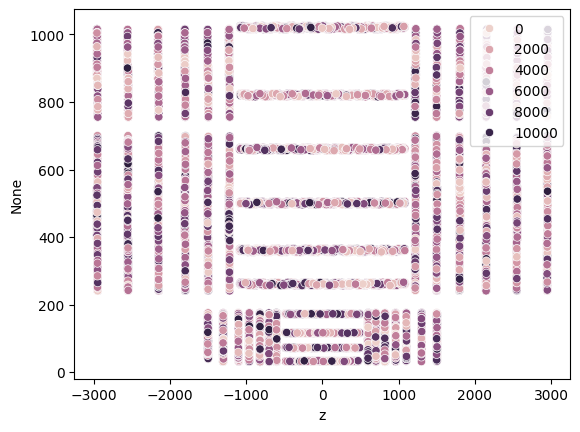

In [245]:
r = (X_train['x']**2 + X_train['y']**2)**0.5
sns.scatterplot(x=X_train['z'], y=r, hue = kmeans.labels_)
plt.xlabel('Z Coordinate of Hit')
plt.ylabel('R Coordinate of Hit')
plt.show()

In [208]:
kmeans2 = KMeans(n_clusters=12, random_state=42)
kmeans2.fit(X_train)

KMeans(n_clusters=12, random_state=42)

In [209]:
kmeans2.score(X_test)

-455294792703.22296

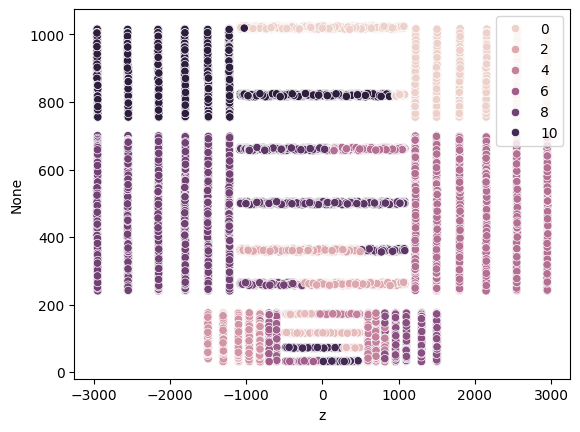

In [244]:
r = (X_train['x']**2 + X_train['y']**2)**0.5
sns.scatterplot(data=X_train, x=X_train['z'], y=r, hue = kmeans2.labels_)
plt.xlabel('Z Coordinate of Hit')
plt.ylabel('R Coordinate of Hit')
plt.title('K Means Clustering Labels with Number of Clusters Equal to 12')
plt.show()

#### 🔹 Unsupervised Learning with DBSCAN

In [218]:
clustering = DBSCAN(eps=0.008, min_samples=1)
clustering.fit(X_train)

DBSCAN(eps=0.008, min_samples=1)

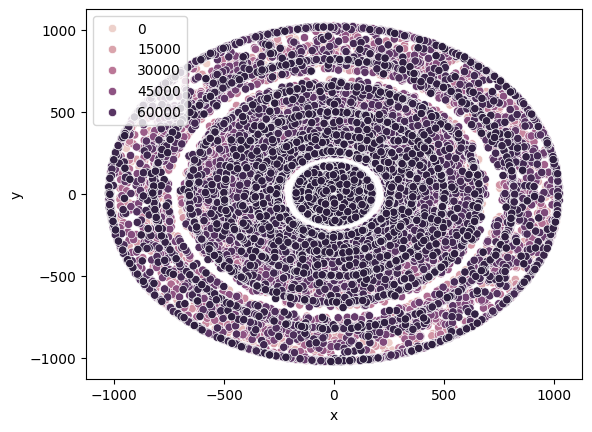

In [222]:
sns.scatterplot(data=X_train, x='x', y='y', hue = clustering.labels_)
plt.xlabel('X Coordinate of Hit')
plt.ylabel('Y Coordinate of Hit')
plt.show()

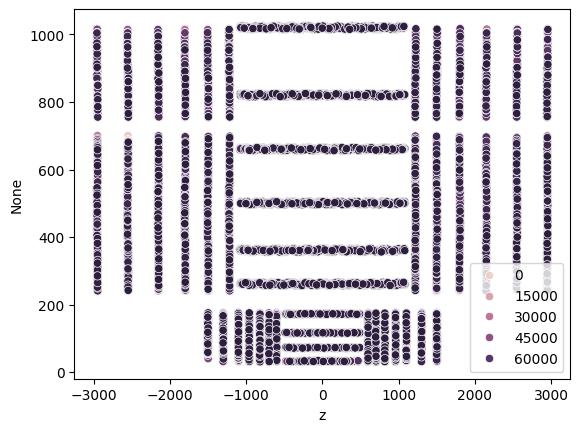

In [219]:
r = (X_train['x']**2 + X_train['y']**2)**0.5
sns.scatterplot(data=X_train, x=X_train['z'], y=r, hue = clustering.labels_)
plt.xlabel('Z Coordinate of Hit')
plt.ylabel('R Coordinate of Hit')
plt.show()

<hr>

## Works Cited

    Anaderi, Andreas Salzburger, CecileGermain, David Rousseau, Guillaume Charpiat, Heather Gray, inversion, Isabelle, JR, Laurent Basara, Maggie, Mikhail Hushchyn, Moritz Kiehn, Paolo Calafiura, Sorme, Steve Farrell. (2018). TrackML Particle Tracking Challenge. Kaggle. https://kaggle.com/competitions/trackml-particle-identification
    
    Atlas Collaboration. “Atlas Searches for New Phenomena Using Unsupervised Machine Learning for Anomaly Detection.” ATLAS, 24 Aug. 2023, atlas.cern/Updates/Briefing/Anomaly-Detection. 

    Brownlee, Jason. “Semi-Supervised Learning with Label Propagation.” MachineLearningMastery.Com, Machine Learning Mastery, 27 Dec. 2020, machinelearningmastery.com/semi-supervised-learning-with-label-propagation/. 

    “Doe Explains...Particle Accelerators.” Energy.Gov Office of Science, US Department of Energy, www.energy.gov/science/doe-explainsparticle-accelerators. Accessed 16 Oct. 2023. 

    Potrimba, Petru. “What Is Semi-Supervised Learning? A Guide for Beginners.” Roboflow Blog, Roboflow Blog, 16 Dec. 2022, blog.roboflow.com/what-is-semi-supervised-learning/.

### Old code 

In [ ]:
# # Get the indices of labeled and unlabeled data
# labeled_indices = hits_track[hits_track['track_id'] != -1].index
# unlabeled_indices = hits_track[hits_track['track_id'] == -1].index

# # Check if the indices are valid for X_train and X_test
# valid_labeled_indices = [idx for idx in labeled_indices if idx in X_train.index]
# valid_unlabeled_indices = [idx for idx in unlabeled_indices if idx in X_test.index]

# # Use the indices to split train and test into labeled and unlabeled
# X_train_lab = X_train.loc[valid_labeled_indices]
# y_train_lab = y_train.loc[valid_labeled_indices]
# X_test_unlab = X_test.loc[valid_unlabeled_indices]
# y_test_unlab = y_test.loc[valid_unlabeled_indices]
# # summarize training set size
# print('Labeled Train Set:', X_train_lab.shape, y_train_lab.shape)
# print('Unlabeled Train Set:', X_test_unlab.shape, y_test_unlab.shape)
# # summarize test set size
# print('Test Set:', X_test.shape, y_test.shape)